# Eurovision 2025: Can we predict the top 10?


In [49]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

## 1. Importing the dataset & cleaning it up 

In [51]:
df = pd.read_csv("eurovision_2016-25.csv", encoding='ISO-8859-1')

df.head(5)
df.shape

(358, 33)

### Let's remove capital letters and spaces from the column names 

In [53]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head(5)

,year,country_,song_,artist_,final_place,final_points,top_5,top_10,running_order_final,grand_final_ind,...,language4,multiple_language,national_language_used,eu,nato,country_group,myesb_community,myesb_personal,ogae_points,qualification_record
0,2025,Albania,Zjerm,Shkodra Elektronike,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,True,0,1,Southern,4,17,158,0.550000
1,2025,Armenia,Survivor,Parg,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,False,0,0,South-Eastern,30,30,0,0.812500
2,2025,Australia,Milkshake Man,Go-Jo,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,True,0,0,Western,17,21,15,0.777778
3,2025,Austria,Wasted Love,JJ,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,False,1,0,Central,1,11,382,0.562500
4,2025,Azerbaijan,Run with U,Mamagama,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,False,0,0,South-Eastern,32,18,0,0.812500


In [54]:
df.shape

(358, 33)

In [55]:
# Looking at the columns
df.columns

Index(['year', 'country_', 'song_', 'artist_', 'final_place', 'final_points',
       'top_5', 'top_10', 'running_order_final', 'grand_final_ind', 'big6_ind',
       'semi_final_num', 'semi_place', 'semi_points', 'running_order_semi',
       'national_final', 'solo_artist', 'sex', 'returning_artist_ind',
       'number_of_members', 'language1', 'language2', 'language3', 'language4',
       'multiple_language', 'national_language_used', 'eu', 'nato',
       'country_group', 'myesb_community', 'myesb_personal', 'ogae_points',
       'qualification_record'],
      dtype='object')

In [56]:
# Removing weird stuff from column names
df.rename(columns={'country_': 'country', 'song_': 'song', 'artist_': 'artist'}, inplace=True)


In [57]:
df.dtypes

year                        int64
country                    object
song                       object
artist                     object
final_place               float64
final_points              float64
top_5                     float64
top_10                    float64
running_order_final       float64
grand_final_ind           float64
big6_ind                    int64
semi_final_num            float64
semi_place                float64
semi_points               float64
running_order_semi        float64
national_final              int64
solo_artist                 int64
sex                        object
returning_artist_ind        int64
number_of_members           int64
language1                  object
language2                  object
language3                  object
language4                  object
multiple_language           int64
national_language_used       bool
eu                          int64
nato                        int64
country_group              object
myesb_communit

### Adding the column descriptions to reference later if necessary

In [59]:
column_descriptions = {
    "year": "Year of contest", # num
    "country": "Country participating", # cat
    "song": "Song title", # dropped
    "artist": "Artist name", # dropped
    "final_place": "Finishing position in Grand Final. Null if artist failed to qualify for final.", # num
    "final_points": "Points achieved by the artist in the final", # num
    "top_5": "Indicator: 1 if the artist finished in the top 5, 0 otherwise.", # cat
    "top_10": "Indicator: 1 if the artist finished in the top 10, 0 otherwise.", # cat
    'running_order_final': "Running order that the artist sung in during the final", # num
    'grand_final_ind': "Indicator. 1 if the artist qualified for the final, 0 otherwise.", # cat
    'big6_ind': "Indicator. 1 if the country is one of the 'Big 6', 0 otherwise.", # cat
    'semi_final_num': "First or second semi final, which the artist participanted in.", # cat
    'semi_place': "Finishing position of the artist in the semi final", # num
    'semi_points': "Points achieved by the artist in the semi final", # num
    'running_order_semi': "Running order that the artist sung in during the semi final", # num
    'national_final': "Indicator, 1 if the artist or song was selected by a national final to represent the country.", # cat
    'solo_artist': "Indicator. 1 if the artist is a solo artist, 0 if they are part of a duet or band.", # cat
    'sex': "Sex of the artist, M - male, F-female, Mixed - both M & F in a band/duet. Biological sex used.", # cat
    'returning_artist_ind': "Indicator. 1 if the artist has participated in Eurovision before, otherwise 0.", # cat
    'number_of_members': "Number of constituent members in the artist", # num
    'language1': "Language of the song.", # cat
    'language2': "Additional language in the song.", # dropped
    'language3': "Additional language in the song.", # dropped
    'language4': "Additional language in the song.", # dropped
    'multiple_language': "Indicator. 1 if there are multiple languages in the song.", # cat
    'national_language_used': "Boolean. Does the song include the country's national language?", # cat
    'eu': "Indicator. 1 if the country is in the EU, 0 otherwise", # cat
    'nato': "Indicator. 1 if the country is in NATO, 0 otherwise.", # cat
    'country_group': "Geographical group of the country.", # cat
    'myesb_community': "The community ranking of songs from the My ESC Scoreboard app.", # num
    'myesb_personal': "My personal ranking.", # dropped
    'ogae_points': "The points from the OGAE official poll.", # num
    'qualification_record': "Proportion of times the country has qualified for the final in decimal form. 1.00 = 100% qualification record before that year" # num
    }


In [60]:
len(column_descriptions)

33

### Dropping unnecessary columns (not useful for my prediction)
- The song name is always random
- The artist name is always random
- The 2nd, 3rd and 4th language are usually NaN - most songs are in 1 language. Moreover, the multiple_language column tells us whether there was 1 or multiple languages sung in
- myesb_personal is the ranking of the person who made the dataset

In [62]:
df = df.drop(['song', 'artist', 'language2', 'language3', 'language4', 'myesb_personal'], axis=1)

### Checking for duplicates and nulls

In [64]:
# Check for duplicates 
df.duplicated().value_counts()

False    358
Name: count, dtype: int64

In [65]:
df.isna().sum()

year                        0
country                     0
final_place               152
final_points              152
top_5                      80
top_10                     75
running_order_final       151
grand_final_ind            31
big6_ind                    0
semi_final_num             53
semi_place                 84
semi_points                84
running_order_semi         53
national_final              0
solo_artist                 0
sex                         0
returning_artist_ind        0
number_of_members           0
language1                   0
multiple_language           0
national_language_used      0
eu                          0
nato                        0
country_group               0
myesb_community             0
ogae_points                 0
qualification_record       46
dtype: int64

In [66]:
# Create training df that excludes 2025
df_train = df[(df['year'] < 2025) & (df['top_10'].notna())].copy()


### Notes on NaNs    
The 2025 NaNs are there because the final hadn't taken place yet.    
Other NaNs exist because of the 'Big 6': 6 countries that qualify no matter what.    
Finally, there are many NaNs in places where countries failed to qualify at all.    
Strategy: Create a training dataset that excludes rows from 2025 and fill NaNs

### Notes on filling NaNs: 
final_place               Null if country did not qualify / 2025 entries -> fill with 0    
final_points              Null if country did not qualify / 2025 entries -> fill with 0     
top_5                     Null if country did not qualify / 2025 entries -> fill with 0     
top_10                    Null if country did not qualify / 2025 entries -> fill with 0     
running_order_final       Null if country did not qualify / 2025 entries -> fill with 0     
grand_final_ind           Null for all 2025 entries except for Big 5     
semi_final_num            Null for Big 6 entries, host countries -> fill with -1      
semi_place                Null for 2025, Big 6, and host countries -> fill with -1     
semi_points               Null for 2025, Big 6, and host countries -> fill with -1     
running_order_semi        Null for Big 6 entries, host countries -> fill with -1     
qualification_record      Null for Big 6 -> fill with 1 (100%)

In [69]:
# Adding a column to specify whether countries had to qualify or not, so the model can make these connections to the other columns
df_train["had_to_qualify"] = df_train["semi_final_num"].notna().astype(int)
df_train

,year,country,final_place,final_points,top_5,top_10,running_order_final,grand_final_ind,big6_ind,semi_final_num,...,language1,multiple_language,national_language_used,eu,nato,country_group,myesb_community,ogae_points,qualification_record,had_to_qualify
38,2024,Armenia,8.0,183.0,NaN,1.0,19.0,1.0,0,2.0,...,Armenian,0,True,0,0,South-Eastern,20,2,0.800000,1
43,2024,Croatia,2.0,547.0,1.0,1.0,23.0,1.0,0,1.0,...,English,0,False,1,1,Southern,3,356,0.470588,1
49,2024,France,4.0,445.0,1.0,1.0,25.0,1.0,1,NaN,...,French,0,True,1,1,Western,11,188,NaN,0
54,2024,Ireland,6.0,278.0,NaN,1.0,10.0,1.0,0,1.0,...,English,0,False,1,0,Western,22,0,0.421053,1
55,2024,Israel,5.0,375.0,1.0,1.0,6.0,1.0,0,2.0,...,English,1,True,0,0,South-Eastern,17,53,0.631579,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,2016,Spain,22.0,77.0,0.0,0.0,19.0,1.0,1,NaN,...,English,0,False,1,1,Western,7,155,NaN,0
354,2016,Sweden,5.0,261.0,0.0,0.0,9.0,1.0,1,NaN,...,English,0,False,1,0,Northern,18,79,0.916667,0
355,2016,Switzerland,NaN,NaN,0.0,0.0,NaN,0.0,0,2.0,...,English,0,False,0,0,Central,36,0,0.333333,1
356,2016,Ukraine,1.0,534.0,0.0,0.0,21.0,1.0,0,2.0,...,English,1,False,0,0,Eastern,4,88,1.000000,1


In [70]:
# Filling NaNs
df_train['final_place'] = df_train['final_place'].fillna(30).astype(int) # Last place is 26, 30 means not qualified
df_train['final_points'] = df_train['final_points'].fillna(0).astype(int) # Zero points is you're not qualified
df_train['running_order_final'] = df_train['running_order_final'].fillna(0).astype(int) # Did not run
df_train['top_10'] = df_train['top_10'].fillna(0).astype(int) # not qualified = not in top 10
df_train['top_5'] = df_train['top_5'].fillna(0).astype(int) # not qualified = not in top 5
df_train['semi_final_num'] = df_train['semi_final_num'].fillna(-1).astype(int) # Did not have to partake in the semis
df_train['semi_place'] = df_train['semi_place'].fillna(-1).astype(int) # Did not have to partake in the semis
df_train['semi_points'] = df_train['semi_points'].fillna(-1).astype(int) # Did not participate, no points
df_train['running_order_semi'] = df_train['running_order_semi'].fillna(-1).astype(int) # Did not run
df_train['qualification_record'] = df_train['qualification_record'].fillna(1).astype(float) # 100 % qualification rate for Big 6

In [71]:
# No NaNs left
df_train.isnull().sum()

year                      0
country                   0
final_place               0
final_points              0
top_5                     0
top_10                    0
running_order_final       0
grand_final_ind           0
big6_ind                  0
semi_final_num            0
semi_place                0
semi_points               0
running_order_semi        0
national_final            0
solo_artist               0
sex                       0
returning_artist_ind      0
number_of_members         0
language1                 0
multiple_language         0
national_language_used    0
eu                        0
nato                      0
country_group             0
myesb_community           0
ogae_points               0
qualification_record      0
had_to_qualify            0
dtype: int64

## 2. One-hot encoding, features and target, train test split, scaling

In [73]:
# Define categorical columns 
cat_cols = [
    "country",
    "top_5",
    # "top_10", not included, this is the target
    "grand_final_ind",
    "big6_ind",
    "semi_final_num",
    "national_final",
    "solo_artist",
    "sex",
    "returning_artist_ind",
    "language1",
    "multiple_language",
    "national_language_used",
    "eu",
    "nato",
    "country_group"
]

# Define numerical columns
num_cols = [
    "year",
    "final_place",
    "final_points",
    "running_order_final",
    "semi_place",
    "semi_points",
    "running_order_semi",
    "number_of_members",
    "myesb_community",
    "ogae_points",
    "qualification_record"
]

print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numerical columns ({len(num_cols)}): {num_cols}")


Categorical columns (15): ['country', 'top_5', 'grand_final_ind', 'big6_ind', 'semi_final_num', 'national_final', 'solo_artist', 'sex', 'returning_artist_ind', 'language1', 'multiple_language', 'national_language_used', 'eu', 'nato', 'country_group']
Numerical columns (11): ['year', 'final_place', 'final_points', 'running_order_final', 'semi_place', 'semi_points', 'running_order_semi', 'number_of_members', 'myesb_community', 'ogae_points', 'qualification_record']


In [74]:
# One-hot encode categorical columns
df_train_dummies = pd.get_dummies(df_train, columns=cat_cols, drop_first=False, dtype=int)

print(f"Original shape: {df_train.shape}")
print(f"After one-hot encoding: {df_train_dummies.shape}")
df_train_dummies.head(5)

Original shape: (283, 28)
After one-hot encoding: (283, 118)


,year,final_place,final_points,top_10,running_order_final,semi_place,semi_points,running_order_semi,number_of_members,myesb_community,...,eu_0,eu_1,nato_0,nato_1,country_group_Central,country_group_Eastern,country_group_Northern,country_group_South-Eastern,country_group_Southern,country_group_Western
38,2024,8,183,1,19,3,137,8,2,20,...,1,0,1,0,0,0,0,1,0,0
43,2024,2,547,1,23,1,177,7,1,3,...,0,1,0,1,0,0,0,0,1,0
49,2024,4,445,1,25,-1,-1,-1,1,11,...,0,1,0,1,0,0,0,0,0,1
54,2024,6,278,1,10,3,124,4,1,22,...,0,1,1,0,0,0,0,0,0,1
55,2024,5,375,1,6,1,194,14,1,17,...,1,0,1,0,0,0,0,1,0,0


### Define features and target, train test split

In [76]:
# Define features and target 
features = df_train_dummies.drop('top_10', axis=1)
target = df_train_dummies['top_10']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

### Scaling

In [78]:
# Scale only num_cols
scaler = StandardScaler()

X_train_scaled_num = scaler.fit_transform(X_train[num_cols])
X_test_scaled_num = scaler.transform(X_test[num_cols])

# Convert scaled arrays back to DataFrames (to make merging easier)
X_train_scaled_num = pd.DataFrame(X_train_scaled_num, columns=num_cols, index=X_train.index)
X_test_scaled_num = pd.DataFrame(X_test_scaled_num, columns=num_cols, index=X_test.index)

# Keep categorical columns unchanged
X_train_cat = X_train.drop(columns=num_cols)
X_test_cat = X_test.drop(columns=num_cols)

# Combine scaled numeric and unchanged categorical columns
X_train_final = pd.concat([X_train_scaled_num, X_train_cat], axis=1)
X_test_final = pd.concat([X_test_scaled_num, X_test_cat], axis=1)

X_train_final.head(5) # Check the numbers


,year,final_place,final_points,running_order_final,semi_place,semi_points,running_order_semi,number_of_members,myesb_community,ogae_points,...,eu_0,eu_1,nato_0,nato_1,country_group_Central,country_group_Eastern,country_group_Northern,country_group_South-Eastern,country_group_Southern,country_group_Western
251,-0.566433,1.150732,-0.845661,-1.047445,1.999331,-1.079990,-0.944973,-0.490123,1.939695,-0.611040,...,1,0,0,1,0,0,1,0,0,0
275,-0.974120,-0.030489,-0.342682,-0.482205,-0.036024,0.434030,1.390882,-0.490123,-0.494301,-0.548863,...,1,0,1,0,0,0,0,1,0,0
232,-0.566433,1.150732,-0.845661,-1.047445,1.320879,-0.372710,1.390882,-0.490123,1.352179,-0.611040,...,1,0,1,0,0,0,0,1,0,0
100,1.472004,0.067946,-0.253546,-0.595253,-0.714476,0.124595,0.222955,-0.490123,0.680732,-0.593275,...,0,1,0,1,0,1,0,0,0,0
248,-0.566433,-1.408579,1.319060,0.196083,-1.392927,-1.256809,-1.445513,-0.490123,-0.913956,-0.309038,...,0,1,0,1,1,0,0,0,0,0


## 3. First model: basic KNN

In [80]:
# Initialize KNN with k=5 neighbors to start
knn = KNeighborsClassifier(n_neighbors=5)

# Fit on training data
knn.fit(X_train_final, y_train)

# Predict on test data
y_pred = knn.predict(X_test_final)
y_proba = knn.predict_proba(X_test_final)[:, 1]  # probabilities for ROC AUC

# Evaluation
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Precision: 1.00
Recall: 0.60
F1-score: 0.75
Confusion Matrix:
 [[47  0]
 [ 4  6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        47
           1       1.00      0.60      0.75        10

    accuracy                           0.93        57
   macro avg       0.96      0.80      0.85        57
weighted avg       0.94      0.93      0.92        57

ROC AUC Score: 0.9308510638297872


In [81]:
# Accuracy ~93% — Great overall correct predictions.

# Confusion Matrix:

# True Negatives (0 predicted as 0): 47 (perfect)
# False Positives: 0 (no false alarms)
# False Negatives: 4 (missed 4 positive cases)
# True Positives: 6 (correctly identified positives)

# Precision for class 1 (top_10 = 1): 1.00 — Every time it predicted positive, it was right.
# Recall for class 1: 0.60 — It only caught 60% of actual positives — some misses.
# F1-score for class 1: 0.75 — Harmonic mean of precision and recall, decent but can improve.

# ROC AUC ~0.93 — Excellent ability to distinguish classes overall.

## 4. Compare KNN model to 2025 data 

In [83]:
# Load 2025 df (hand-edited before uploading)
df25 = pd.read_csv("eurovision_2025.csv", sep=";")
df25

,Year,Country,Final_Place,Final_Points,Top 5,Top 10,Running_Order_Final,Grand_Final_Ind,Grand_Final_Ind.1,Big6_Ind,...,Number of Members,Language1,Multiple_Language,National_Language_Used,EU,NATO,Country_Group,MyESB_Community,OGAE_Points,Qualification_Record
0,2025,Albania,8.0,218.0,0.0,1.0,26.0,1,0,0.0,...,2,Albanian,0,True,0,1,Southern,4,158,0.550000
1,2025,Armenia,20.0,72.0,0.0,0.0,18.0,1,0,0.0,...,1,English,0,False,0,0,South-Eastern,30,0,0.812500
2,2025,Australia,30.0,0.0,0.0,0.0,0.0,0,0,0.0,...,1,English,0,True,0,0,Western,17,15,0.777778
3,2025,Austria,1.0,436.0,1.0,1.0,9.0,1,0,0.0,...,1,English,0,False,1,0,Central,1,382,0.562500
4,2025,Azerbaijan,30.0,0.0,0.0,0.0,0.0,0,0,0.0,...,3,English,0,False,0,0,South-Eastern,32,0,0.812500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,2016,Spain,22.0,77.0,0.0,0.0,19.0,1,1,NaN,...,1,English,0,False,1,1,Western,7,155,NaN
354,2016,Sweden,5.0,261.0,0.0,0.0,9.0,1,1,NaN,...,1,English,0,False,1,0,Northern,18,79,0.916667
355,2016,Switzerland,NaN,NaN,0.0,0.0,NaN,0,0,NaN,...,1,English,0,False,0,0,Central,36,0,0.333333
356,2016,Ukraine,1.0,534.0,0.0,0.0,21.0,1,0,NaN,...,1,English,1,False,0,0,Eastern,4,88,1.000000


### Make sure df25 is the same as the training set: dummies, column names

In [85]:
# Unify column names
df25.columns = df25.columns.str.lower().str.replace(' ', '_')
# Removing weird stuff from column names
df25.rename(columns={'country_': 'country'}, inplace=True)
# Drop all years before 2025 
df25 = df25[(df25['year'] == 2025)]
# Adding a column to specify whether countries had to qualify or not
df25.loc[df25['country'] == 'United Kingdom', 'semi_final_num'] = -1 # UK was wrong in this column 
df25["had_to_qualify"] = (df25["semi_final_num"] != -1).astype(int)
 # drop top_10
df25 = df25.drop(columns=['top_10'], errors='ignore')

/var/folders/w6/_0ncg7691l37ydc3hj5bp73r0000gn/T/ipykernel_31028/1197906995.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df25["had_to_qualify"] = (df25["semi_final_num"] != -1).astype(int)


In [86]:
# Dropping a weird column that shouldn't be there (something happened with the editing of the csv file)
df25 = df25.drop(columns='grand_final_ind.1', errors='ignore')

df25.shape

(37, 27)

In [87]:
# Check for nulls
df25.isna().sum()

year                      0
country                   0
final_place               0
final_points              0
top_5                     0
running_order_final       0
grand_final_ind           0
big6_ind                  0
semi_final_num            0
semi_place                0
semi_points               0
running_order_semi        0
national_final            0
solo_artist               0
sex                       0
returning_artist_ind      0
number_of_members         0
language1                 0
multiple_language         0
national_language_used    0
eu                        0
nato                      0
country_group             0
myesb_community           0
ogae_points               0
qualification_record      0
had_to_qualify            0
dtype: int64

In [88]:
# One-hot encode categorical columns
df25_dummies = pd.get_dummies(df25, columns=cat_cols, drop_first=False, dtype=int)

print(f"Original shape: {df25.shape}")
print(f"After one-hot encoding: {df25_dummies.shape}")
df25_dummies.head(5)

Original shape: (37, 27)
After one-hot encoding: (37, 100)


,year,final_place,final_points,running_order_final,semi_place,semi_points,running_order_semi,number_of_members,myesb_community,ogae_points,...,eu_0,eu_1,nato_0,nato_1,country_group_Central,country_group_Eastern,country_group_Northern,country_group_South-Eastern,country_group_Southern,country_group_Western
0,2025,8.0,218.0,26.0,2.0,122.0,12.0,2,4,158,...,1,0,0,1,0,0,0,0,1,0
1,2025,20.0,72.0,18.0,10.0,51.0,5.0,1,30,0,...,1,0,1,0,0,0,0,1,0,0
2,2025,30.0,0.0,0.0,11.0,41.0,1.0,1,17,15,...,1,0,1,0,0,0,0,0,0,1
3,2025,1.0,436.0,9.0,5.0,104.0,6.0,1,1,382,...,0,1,1,0,1,0,0,0,0,0
4,2025,30.0,0.0,0.0,15.0,7.0,10.0,3,32,0,...,1,0,1,0,0,0,0,1,0,0


In [89]:
# Check difference between column names (ARE in df25 but not in train)
print(df25_dummies.columns.difference(X_train_final.columns))


Index(['big6_ind_0.0', 'big6_ind_1.0', 'country_Luxembourg',
       'grand_final_ind_0', 'grand_final_ind_1', 'language1_German',
       'language1_Latvian', 'language1_Swedish', 'semi_final_num_-1.0',
       'semi_final_num_1.0', 'semi_final_num_2.0', 'top_5_0.0', 'top_5_1.0'],
      dtype='object')


In [90]:
# Replace '.0' suffix in column names if present
df25_dummies.columns = [col.replace('.0', '') if isinstance(col, str) else col for col in df25_dummies.columns]


In [91]:
# Check difference between column names again
print(df25_dummies.columns.difference(X_train_final.columns))

Index(['country_Luxembourg', 'grand_final_ind_0', 'grand_final_ind_1',
       'language1_German', 'language1_Latvian', 'language1_Swedish'],
      dtype='object')


In [92]:
# columns that ARE in train but not in df25
print(X_train_final.columns.difference(df25_dummies.columns))

Index(['country_Belarus', 'country_Bosnia & Herzegovina', 'country_Bulgaria',
       'country_FYR Macedonia', 'country_Hungary', 'country_Moldova',
       'country_North Macedonia', 'country_Romania', 'country_Russia',
       'grand_final_ind_0.0', 'grand_final_ind_1.0', 'language1_Armenian',
       'language1_Belarusian', 'language1_Bosnian', 'language1_Breton',
       'language1_Croatian', 'language1_Danish', 'language1_Dutch',
       'language1_Hungarian', 'language1_Macedonian', 'language1_Romanian',
       'language1_Russian', 'language1_Slovene'],
      dtype='object')


In [93]:
# Rename grand final columns so they match 
df25_dummies.rename(columns={
    'grand_final_ind_0': 'grand_final_ind_0.0',
    'grand_final_ind_1': 'grand_final_ind_1.0'
}, inplace=True)


In [94]:
# Drop language columns that are in df25 but not in train
extra_language_cols = ['language1_German', 'language1_Latvian', 'language1_Swedish']
df25_dummies.drop(columns=extra_language_cols, inplace=True)

# Same for country
extra_country_cols = ['country_Luxembourg']
df25_dummies.drop(columns=extra_country_cols, inplace=True)


In [95]:
# Add missing languages to df25
missing_language_cols = [
    'language1_Armenian', 'language1_Belarusian', 'language1_Bosnian',
    'language1_Breton', 'language1_Croatian', 'language1_Danish',
    'language1_Dutch', 'language1_Hungarian', 'language1_Macedonian',
    'language1_Romanian', 'language1_Russian', 'language1_Slovene'
]

for col in missing_language_cols:
    df25_dummies[col] = 0

# Same for countries 
missing_country_cols = [
    'country_Belarus', 'country_Bosnia & Herzegovina', 'country_Bulgaria',
    'country_FYR Macedonia', 'country_Hungary', 'country_Moldova',
    'country_North Macedonia', 'country_Romania', 'country_Russia'
]

for col in missing_country_cols:
    df25_dummies[col] = 0


In [96]:
df25_dummies = df25_dummies[X_train_final.columns]



### Scaling

In [98]:
# Scale numeric columns in df25_dummies using the previously fitted scaler
df25_scaled_num = scaler.transform(df25_dummies[num_cols])

# Convert scaled array back to DataFrame
df25_scaled_num = pd.DataFrame(df25_scaled_num, columns=num_cols, index=df25_dummies.index)

# Get the unscaled categorical part
df25_cat = df25_dummies.drop(columns=num_cols)

# Combine scaled numeric and unscaled categorical parts
df25_final = pd.concat([df25_scaled_num, df25_cat], axis=1)


### Predict 2025

In [100]:
y_pred_2025_knn = knn.predict(df25_final)

In [101]:
# Adding a column to the original df
df25['knn_predicted_top_10'] = y_pred_2025_knn


In [102]:
df25_top10 = pd.read_csv("top_10_eurovision_2025.csv", sep=";")
df25_top10

,year,country,top_10
0,2025,Albania,1
1,2025,Armenia,0
2,2025,Australia,0
3,2025,Austria,1
4,2025,Azerbaijan,0
5,2025,Belgium,0
6,2025,Croatia,0
7,2025,Cyprus,0
8,2025,Czech Republic,0
9,2025,Denmark,0


### Get basic KNN results

In [104]:
df25_knn_results = df25.merge(df25_top10, on='country', how='left')
# Keep only the columns you want
df25_knn_results = df25_knn_results[['country', 'top_10', 'knn_predicted_top_10']]
df25_knn_results

,country,top_10,knn_predicted_top_10
0,Albania,1,0
1,Armenia,0,0
2,Australia,0,0
3,Austria,1,1
4,Azerbaijan,0,0
5,Belgium,0,0
6,Croatia,0,0
7,Cyprus,0,0
8,Czech Republic,0,0
9,Denmark,0,0


In [105]:
# Matches where both are 1
matches_ones = ((df25_knn_results['top_10'] == 1) & (df25_knn_results['knn_predicted_top_10'] == 1)).sum()

# Matches where both are 0
matches_zeros = ((df25_knn_results['top_10'] == 0) & (df25_knn_results['knn_predicted_top_10'] == 0)).sum()

print(f"Number of matching 1s: {matches_ones} out of 10")
print(f"Number of matching 0s: {matches_zeros} out of 27")


Number of matching 1s: 7 out of 10
Number of matching 0s: 26 out of 27


In [106]:
# Correctly predicted top_10s (1s)
correct_positives = df25_knn_results[
    (df25_knn_results['top_10'] == 1) & (df25_knn_results['knn_predicted_top_10'] == 1)
]['country'].tolist()

# Correctly predicted non-top_10s (0s)
correct_negatives = df25_knn_results[
    (df25_knn_results['top_10'] == 0) & (df25_knn_results['knn_predicted_top_10'] == 0)
]['country'].tolist()

# False positives: predicted top 10, but weren't
false_positives = df25_knn_results[
    (df25_knn_results['top_10'] == 0) & (df25_knn_results['knn_predicted_top_10'] == 1)
]['country'].tolist()

# False negatives: were top 10, but predicted not
false_negatives = df25_knn_results[
    (df25_knn_results['top_10'] == 1) & (df25_knn_results['knn_predicted_top_10'] == 0)
]['country'].tolist()

# Display results
print("✅ Correctly predicted top 10 countries:")
print(", ".join(correct_positives))

print("\n✅ Correctly predicted non-top 10 countries:")
print(", ".join(correct_negatives))

print("\n❌ False positives (predicted top 10, but were not):")
print(", ".join(false_positives))

print("\n❌ False negatives (actually top 10, but predicted not):")
print(", ".join(false_negatives))


✅ Correctly predicted top 10 countries:
Austria, Estonia, France, Greece, Israel, Sweden, Ukraine

✅ Correctly predicted non-top 10 countries:
Armenia, Australia, Azerbaijan, Belgium, Croatia, Cyprus, Czech Republic, Denmark, Finland, Georgia, Germany, Iceland, Ireland, Latvia, Lithuania, Luxembourg, Montenegro, Netherlands, Norway, Poland, Portugal, San Marino, Serbia, Slovenia, Spain, United Kingdom

❌ False positives (predicted top 10, but were not):
Malta

❌ False negatives (actually top 10, but predicted not):
Albania, Italy, Switzerland


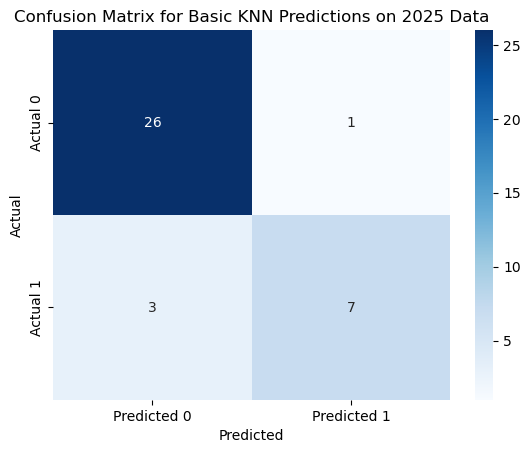

In [200]:
# True labels for 2025 data
y_true_2025 = df25_top10['top_10']

# Your predictions for 2025 (already predicted)
y_pred_2025_knn = df25['knn_predicted_top_10']

cm = confusion_matrix(y_true_2025, y_pred_2025_knn)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Basic KNN Predictions on 2025 Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## 5. KNN - finetuned with SMOTE, GridSearch

### SMOTE

In [110]:
# Apply SMOTE to handle class imbalance in training set
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_smote).value_counts().to_dict())


Before SMOTE: {0: 194, 1: 32}
After SMOTE: {0: 194, 1: 194}


In [111]:
# Define hyperparameter grid
param_grid = {'n_neighbors': list(range(1, 21))}

# Initialize KNN and run GridSearchCV
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=5, scoring='f1')
grid.fit(X_train_smote, y_train_smote)

# Output best value for k
print("Best k:", grid.best_params_['n_neighbors'])


Best k: 2


In [112]:
# Train with best k
best_knn = grid.best_estimator_
best_knn.fit(X_train_smote, y_train_smote)

# Predict on test set
y_pred = best_knn.predict(X_test_final)

# Evaluate performance
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Precision: 0.88
Recall: 0.70
F1-score: 0.78
[[46  1]
 [ 3  7]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        47
           1       0.88      0.70      0.78        10

    accuracy                           0.93        57
   macro avg       0.91      0.84      0.87        57
weighted avg       0.93      0.93      0.93        57



#### Earlier classification report: 
Confusion Matrix:
 [[47  0]
 [ 4  6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        47
           1       1.00      0.60      0.75        10

    accuracy                           0.93        57
   macro avg       0.96      0.80      0.85        57
weighted avg       0.94      0.93      0.92        57

### Predict 2025

In [115]:
# Predict using the tuned model
y_pred_2025_best_knn = best_knn.predict(df25_final)

# Add predictions as a new column to original df25
df25['best_knn_predicted_top_10'] = y_pred_2025_best_knn



### Get best KNN results

In [117]:
df25_best_knn_results = df25.merge(df25_top10, on='country', how='left')
# Keep only the columns I want
df25_best_knn_results = df25_best_knn_results[['country', 'top_10', 'best_knn_predicted_top_10']]
df25_best_knn_results

,country,top_10,best_knn_predicted_top_10
0,Albania,1,1
1,Armenia,0,0
2,Australia,0,0
3,Austria,1,1
4,Azerbaijan,0,0
5,Belgium,0,0
6,Croatia,0,0
7,Cyprus,0,0
8,Czech Republic,0,0
9,Denmark,0,1


In [118]:
# Matches where both are 1
matches_ones = ((df25_best_knn_results['top_10'] == 1) & (df25_best_knn_results['best_knn_predicted_top_10'] == 1)).sum()

# Matches where both are 0
matches_zeros = ((df25_best_knn_results['top_10'] == 0) & (df25_best_knn_results['best_knn_predicted_top_10'] == 0)).sum()

print(f"Number of matching 1s: {matches_ones} out of 10")
print(f"Number of matching 0s: {matches_zeros} out of 27")


Number of matching 1s: 10 out of 10
Number of matching 0s: 22 out of 27


In [119]:
# Correctly predicted top_10s (1s)
correct_positives = df25_best_knn_results[
    (df25_best_knn_results['top_10'] == 1) & (df25_best_knn_results['best_knn_predicted_top_10'] == 1)
]['country'].tolist()

# Correctly predicted non-top_10s (0s)
correct_negatives = df25_best_knn_results[
    (df25_best_knn_results['top_10'] == 0) & (df25_best_knn_results['best_knn_predicted_top_10'] == 0)
]['country'].tolist()

# False positives: predicted top 10, but weren't
false_positives = df25_knn_results[
    (df25_best_knn_results['top_10'] == 0) & (df25_best_knn_results['best_knn_predicted_top_10'] == 1)
]['country'].tolist()

# False negatives: were top 10, but predicted not
false_negatives = df25_knn_results[
    (df25_best_knn_results['top_10'] == 1) & (df25_best_knn_results['best_knn_predicted_top_10'] == 0)
]['country'].tolist()

# Display results
print("✅ Correctly predicted top 10 countries:")
print(", ".join(correct_positives))

print("\n✅ Correctly predicted non-top 10 countries:")
print(", ".join(correct_negatives))

print("\n❌ False positives (predicted top 10, but were not):")
print(", ".join(false_positives))

print("\n❌ False negatives (actually top 10, but predicted not):")
print(", ".join(false_negatives))


✅ Correctly predicted top 10 countries:
Albania, Austria, Estonia, France, Greece, Israel, Italy, Sweden, Switzerland, Ukraine

✅ Correctly predicted non-top 10 countries:
Armenia, Australia, Azerbaijan, Belgium, Croatia, Cyprus, Czech Republic, Georgia, Germany, Iceland, Ireland, Latvia, Lithuania, Luxembourg, Montenegro, Netherlands, Norway, Portugal, Serbia, Slovenia, Spain, United Kingdom

❌ False positives (predicted top 10, but were not):
Denmark, Finland, Malta, Poland, San Marino

❌ False negatives (actually top 10, but predicted not):



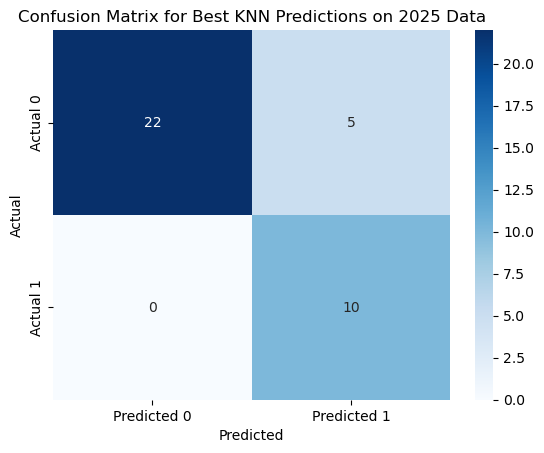

In [120]:
# True labels for 2025 data
y_true_2025 = df25_top10['top_10']

# Your predictions for 2025 (already predicted)
y_pred_2025_best_knn = df25['best_knn_predicted_top_10']

cm = confusion_matrix(y_true_2025, y_pred_2025_best_knn)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Best KNN Predictions on 2025 Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

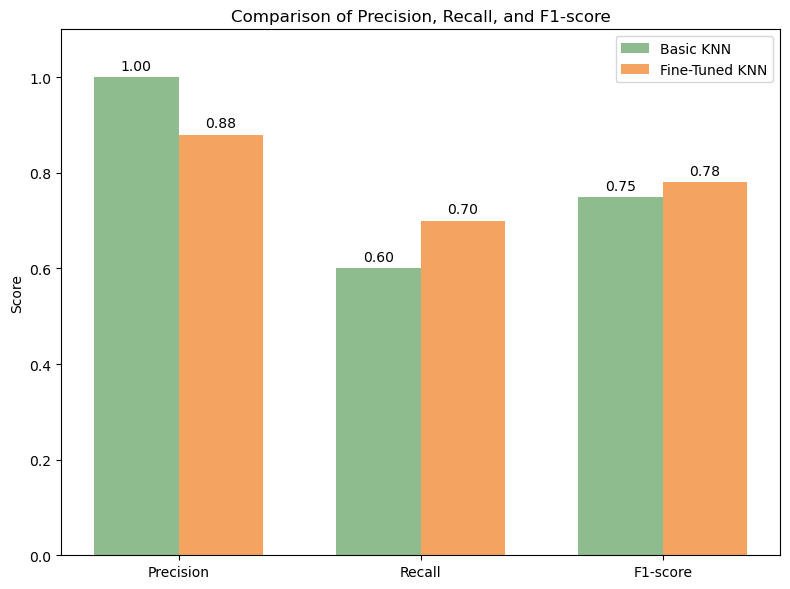

In [121]:
# Comparison chart 

# Metrics
metrics = ['Precision', 'Recall', 'F1-score']
basic_knn = [1.00, 0.60, 0.75]
fine_tuned_knn = [0.88, 0.70, 0.78]

# Bar positions
x = np.arange(len(metrics))
width = 0.35  # width of the bars

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, basic_knn, width, label='Basic KNN', color='darkseagreen')
bars2 = ax.bar(x + width/2, fine_tuned_knn, width, label='Fine-Tuned KNN', color='sandybrown')

# Labels and formatting
ax.set_ylabel('Score')
ax.set_title('Comparison of Precision, Recall, and F1-score')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.1)
ax.legend()

# Annotate bars with values
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


## 6. Next model: Random Forest 

In [202]:
# Create pipeline with SMOTE and Random Forest
rf_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Hyperparameter grid for tuning
rf_param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
    'rf__max_features': ['sqrt', 'log2']
}

# Grid search with 5-fold CV
rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
rf_grid_search.fit(X_train, y_train)

# Best model
best_rf = rf_grid_search.best_estimator_

# Predict on test set
y_pred_rf = best_rf.predict(X_test)

# Evaluate
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        47
           1       1.00      0.80      0.89        10

    accuracy                           0.96        57
   macro avg       0.98      0.90      0.93        57
weighted avg       0.97      0.96      0.96        57

Precision: 1.00
Recall: 0.80
F1-score: 0.89


### Compare to actual 2025 data

In [125]:
# Match columns exactly with training data
X_2025_final = df25_dummies.reindex(columns=X_train.columns, fill_value=0)


In [126]:
# Predict
y_pred_2025_rf = best_rf.predict(X_2025_final)
y_probs_2025_rf = best_rf.predict_proba(X_2025_final)[:, 1]

# Add results to df25
df25['rf_predicted_top_10'] = y_pred_2025_rf
df25['rf_prob_top_10'] = y_probs_2025_rf


### Get RandomForest results

In [128]:
df25_rf_results = df25.merge(df25_top10, on='country', how='left')
# Keep only the columns I want
df25_rf_results = df25_rf_results[['country', 'top_10', 'rf_predicted_top_10']]
df25_rf_results

,country,top_10,rf_predicted_top_10
0,Albania,1,1
1,Armenia,0,0
2,Australia,0,0
3,Austria,1,1
4,Azerbaijan,0,0
5,Belgium,0,0
6,Croatia,0,0
7,Cyprus,0,0
8,Czech Republic,0,0
9,Denmark,0,0


In [129]:
# Matches where both are 1
matches_ones = ((df25_rf_results['top_10'] == 1) & (df25_rf_results['rf_predicted_top_10'] == 1)).sum()

# Matches where both are 0
matches_zeros = ((df25_rf_results['top_10'] == 0) & (df25_rf_results['rf_predicted_top_10'] == 0)).sum()

print(f"Number of matching 1s: {matches_ones} out of 10")
print(f"Number of matching 0s: {matches_zeros} out of 27")



Number of matching 1s: 10 out of 10
Number of matching 0s: 27 out of 27


In [130]:
# Correctly predicted top_10s (1s)
correct_positives = df25_rf_results[
    (df25_rf_results['top_10'] == 1) & (df25_rf_results['rf_predicted_top_10'] == 1)
]['country'].tolist()

# Correctly predicted non-top_10s (0s)
correct_negatives = df25_rf_results[
    (df25_rf_results['top_10'] == 0) & (df25_rf_results['rf_predicted_top_10'] == 0)
]['country'].tolist()

# False positives: predicted top 10, but weren't
false_positives = df25_rf_results[
    (df25_rf_results['top_10'] == 0) & (df25_rf_results['rf_predicted_top_10'] == 1)
]['country'].tolist()

# False negatives: were top 10, but predicted not
false_negatives = df25_rf_results[
    (df25_rf_results['top_10'] == 1) & 
    (df25_rf_results['rf_predicted_top_10'] == 0)
]['country'].tolist()

# Display results
print("✅ Correctly predicted top 10 countries:")
print(", ".join(correct_positives))

print("\n✅ Correctly predicted non-top 10 countries:")
print(", ".join(correct_negatives))

print("\n❌ False positives (predicted top 10, but were not):")
print(", ".join(false_positives))

print("\n❌ False negatives (actually top 10, but predicted not):")
print(", ".join(false_negatives))



✅ Correctly predicted top 10 countries:
Albania, Austria, Estonia, France, Greece, Israel, Italy, Sweden, Switzerland, Ukraine

✅ Correctly predicted non-top 10 countries:
Armenia, Australia, Azerbaijan, Belgium, Croatia, Cyprus, Czech Republic, Denmark, Finland, Georgia, Germany, Iceland, Ireland, Latvia, Lithuania, Luxembourg, Malta, Montenegro, Netherlands, Norway, Poland, Portugal, San Marino, Serbia, Slovenia, Spain, United Kingdom

❌ False positives (predicted top 10, but were not):


❌ False negatives (actually top 10, but predicted not):



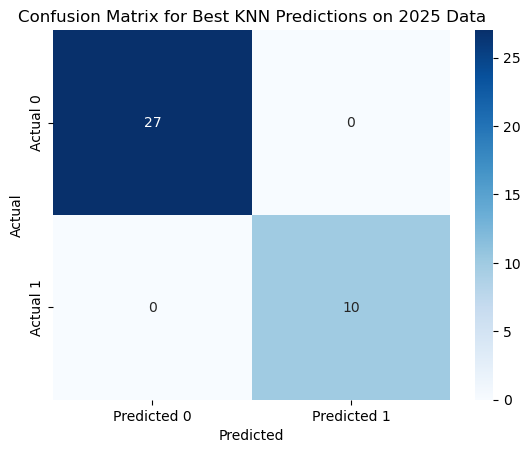

In [131]:
# True labels for 2025 data
y_true_2025 = df25_top10['top_10']

# Your predictions for 2025 (already predicted)
y_pred_2025_rf = df25['rf_predicted_top_10']

cm = confusion_matrix(y_true_2025, y_pred_2025_rf)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix for Best KNN Predictions on 2025 Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

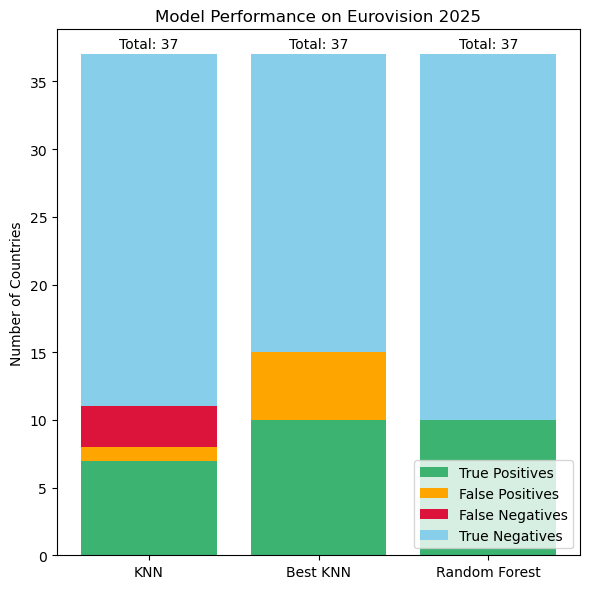

In [132]:
labels = ['KNN', 'Best KNN', 'Random Forest']
tp = [7, 10, 10]
tn = [26, 22, 27]
fp = [1, 5, 0]
fn = [3, 0, 0]

x = np.arange(len(labels))
width = 0.8

fig, ax = plt.subplots(figsize=(6, 6))

# Stack starting from 0 → TP → FP → FN → TN
p1 = ax.bar(x, tp, width, label='True Positives', color='mediumseagreen')
p2 = ax.bar(x, fp, width, bottom=tp, label='False Positives', color='orange')
p3 = ax.bar(x, fn, width, bottom=np.array(tp)+np.array(fp), label='False Negatives', color='crimson')
p4 = ax.bar(x, tn, width, bottom=np.array(tp)+np.array(fp)+np.array(fn), label='True Negatives', color='skyblue')

ax.set_ylabel('Number of Countries')
ax.set_title('Model Performance on Eurovision 2025')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add total label above each bar
for i in range(len(labels)):
    total = tp[i] + tn[i] + fp[i] + fn[i]
    ax.text(x[i], total + 0.5, f'Total: {total}', ha='center')

plt.tight_layout()
plt.show()

